In [35]:
import time
import socket
import json
import struct
import pickle
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import sys
import math


sys.path.append(os.path.realpath('../'))
from sort import *


In [7]:
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
mot_tracker = Sort() 

# cfg.merge_from_file("./configs/bitrap_np_JAAD.yml")
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Using cache found in C:\Users\sonor/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-11-7 Python-3.9.15 torch-1.13.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


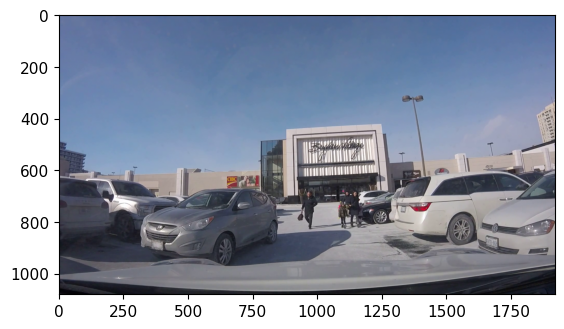

In [8]:
cv_image = cv2.imread(f"../data/JAAD/images/video_0005/00046.png")
plt.imshow(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
class Person:
    def __init__(self, id):
        self.id = id
        # Form is x1, y1, x2, y2, id
        self.frames = []
    
    def add_frame(self, frame):
        self.frames.append(frame)
        return len(self.frames) >= 15

    def get_prediction_frames(self):
        frames = self.frames[:15]
        self.frames.pop(0)
        return frames

    def __len__(self):
        return len(self.frames)

    def __str__(self):
        return f"Person {self.id}, with {len(self.frames)} frames"

In [26]:
result = yolo(f"../data/JAAD/images/video_0005/00046.png")
ids_to_update = []
ids = {}
bounding_boxes = []

for j in result.pred:

    detections = j.cpu().numpy()
    people = []


    for i, prediction in enumerate(detections):
        if prediction[5] == 0:
            people.append(prediction)
    if len(people) > 0:
    # detections = np.where(detections[i][5] == 0 for i in range(len(detections)))
        track_bbs_ids = mot_tracker.update(np.array(people))



        for j, coords in enumerate(track_bbs_ids.tolist()):
            x1, y1, x2, y2, name_idx = int(coords[0]), int(coords[1]), int(coords[2]), int(coords[3]), int(coords[4])
            name = f"ID: {name_idx}"

            if name_idx not in ids.keys():
                ids[name_idx] = Person(id)                    
            
            if ids[name_idx].add_frame(coords):
                ids_to_update.append(name_idx)
            
            cv2.rectangle(cv_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
            bounding_boxes.append(((x1, y1), (x2, y2)))
print(bounding_boxes)

[((1080, 704), (1125, 825)), ((1117, 682), (1167, 824)), ((934, 679), (1001, 826))]


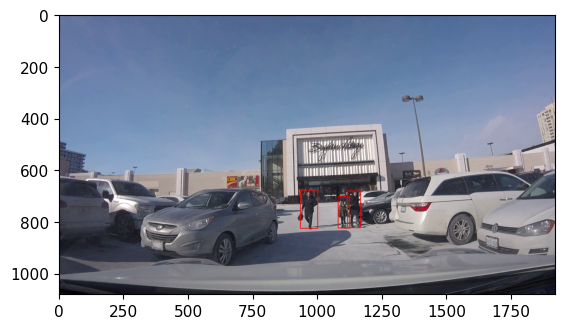

In [28]:
plt.imshow(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
plt.show()

In [39]:
# Compute the Angle to each red box
image_resolution = (1920, 1080)
center_of_image = (image_resolution[0] // 2, image_resolution[1] // 2)
# Find HFOV and VFOV for camera
HFOV = 122.6
VFOV = 94.4

In [46]:
angles = []

for bounding_box in bounding_boxes:
    # Calculate the center of the bounding box
    center_bounding_box_x = (bounding_box[1][0] + bounding_box[0][0]) / 2
    center_bounding_box_y = (bounding_box[1][1] + bounding_box[0][1]) / 2
    
    h_angle = ((center_bounding_box_x - center_of_image[0]) / center_of_image[0]) * (HFOV / 2)
    v_angle = ((center_bounding_box_y - center_of_image[1]) / center_of_image[1]) * (VFOV / 2)

    angles.append(math.sqrt((h_angle ** 2 + v_angle ** 2)))

print(angles)




[21.629989766668125, 21.947208095247987, 18.580247008731607]


In [13]:
# reconstruction = np.array([[0., 0., 0., 0.]])

# for person_id in ids_to_update:
#     data_to_predict_on = []

#     bounding_boxes = ids[person_id].get_prediction_frames()
      
#     for j, row in enumerate(bounding_boxes):
#         bbox = np.array([[row[0], row[1], row[2], row[3]]])
#         reconstruction[..., [0, 1]] = bbox[..., [0, 1]]
#         bbox[..., [2, 3]] = bbox[..., [2, 3]] - bbox[..., [0, 1]]
#         reconstruction[..., [2, 3]] = bbox[..., [2, 3]] / 2
#         bbox[..., [0, 1]] += bbox[..., [2, 3]]/2

#         bbox = (bbox - _min) / (_max - _min)
#         data_to_predict_on.append(bbox[0])
    
#     # Should have length greater than 15, due to it only being for looped if that holds true
#     prediction_data = torch.FloatTensor(np.array(data_to_predict_on[:15])).to(device)
#     prediction_data = prediction_data.unsqueeze(0)
#     cur_pos = prediction_data[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM]
#     pred_traj, pred_goal = predict(model, prediction_data, cur_pos=prediction_data[-1, :cfg.MODEL.DEC_OUTPUT_DIM])
#     pred_goal = pred_goal.detach().to('cpu').numpy() * (_max - _min) + _min
#     pred_traj = pred_traj.detach().to('cpu').numpy() * (_max - _min) + _min
#     for traj in pred_traj:
#         for i, frames in enumerate(traj):
#             box = frames[0]
#             box[0] -= reconstruction[0][2]
#             box[1] -= reconstruction[0][3]
#             box[2] += reconstruction[0][0]
#             box[3] += reconstruction[0][1]


#             if i < len(traj) - 1:
                
#             # Compute the center of each bounding box
#                 centerX = box[2] + box[0] / 2
#                 centerY = box[3] + box[1] / 2

#                 nextBox = traj[i + 1][0]
#                 nextCenterX = nextBox[2] + nextBox[0] / 2
#                 nextCenterY = nextBox[3] + nextBox[1] / 2
#                 x, y, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
#                 cv2.rectangle(cv_image, (x, h), (w, h + 1), (255, 0, 0), 1)

#     for goal in pred_goal:
#         location = goal[0]


#         location[0] -= reconstruction[0][2]
#         location[1] -= reconstruction[0][3]
#         location[2] += reconstruction[0][0]
#         location[3] += reconstruction[0][1]
#         x, y, w, h = int(location[0]), int(location[1]), int(location[2]), int(location[3])
#         cv2.rectangle(cv_image, (x, y), (int(w) , int(h)), (0, 255, 0), 2)
